In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
y_df = pd.DataFrame(mnist['target'])
X_df = pd.DataFrame(mnist['data']).astype(float)
data_df = pd.concat([y_df, X_df], axis=1)

In [4]:
data_df.iloc[:,0].value_counts()

class
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: count, dtype: int64

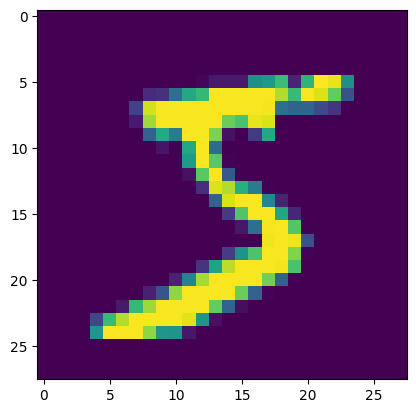

In [5]:
first_image = data_df.iloc[0, 1:].to_numpy(dtype=float)
first_image = first_image.reshape((28, 28))
plt.imshow(first_image)

In [6]:
X = data_df.iloc[:, 1:]
y = data_df.iloc[:, 0]

In [7]:
from sklearn.model_selection import train_test_split
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=1/7, random_state=42)


In [8]:
train_df = pd.concat([y_train_df, X_train_df], axis=1)
test_df = pd.concat([y_test_df, X_test_df], axis=1)

In [9]:
from skimage.transform import AffineTransform, warp

def shift(images, vector):
    # 2D 處理
    if isinstance(images, pd.DataFrame):
        images = images.to_numpy()
    
    shifted_images = []
    for img in images:
        transform = AffineTransform(translation=vector)
        shifted_img = warp(img, transform, mode='constant', cval=0, preserve_range=True)
        shifted_images.append(shifted_img)
    
    return np.array(shifted_images)

In [10]:
X_train_1D = X_train_df.to_numpy()
X_train_2D = X_train_1D.reshape((len(X_train_1D), 28, 28))
X_augmented_2D = shift(X_train_2D, [2, 1])
y_augmented = y_train_df.to_numpy()

In [11]:
X_augmented_1D = X_augmented_2D.reshape((len(X_augmented_2D),28*28))
X_augmented_1D.shape

(60000, 784)

In [12]:
from sklearn.model_selection import KFold
def create_kfolds(X_train_df, y_train_df, X_augmented, y_augmented, cv=3):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    train_folds = []
    val_folds = []

    X_augmented_array = X_augmented.to_numpy() if isinstance(X_augmented, pd.DataFrame) else X_augmented
    y_augmented_array = y_augmented.to_numpy() if isinstance(y_augmented, pd.Series) else y_augmented

    for train_index, val_index in kf.split(X_train_df):
        X_train = X_train_df.iloc[train_index].to_numpy()
        y_train = y_train_df.iloc[train_index].to_numpy()
        
        X_val = X_train_df.iloc[val_index].to_numpy()
        y_val = y_train_df.iloc[val_index].to_numpy()
        
        
        X_combined_train = np.concatenate((X_train, X_augmented_array))
        y_combined_train = np.concatenate((y_train, y_augmented_array))
        
        
        train_folds.append((X_combined_train, y_combined_train))
        val_folds.append((X_val, y_val))
    
    return train_folds, val_folds


In [13]:
train_folds, val_folds = create_kfolds(
    X_train_df=X_train_df,
    y_train_df=y_train_df,
    X_augmented=X_augmented_1D,
    y_augmented=y_augmented
    )

9


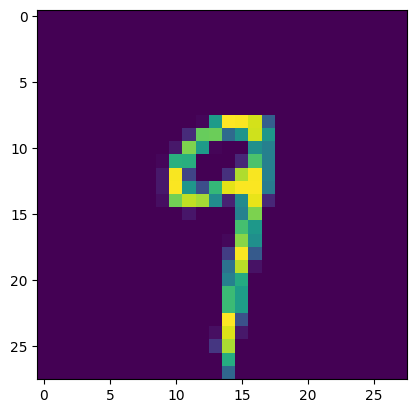

In [14]:
images, labels = train_folds[0]
index = 12423
plt.imshow(images[index].reshape((28,28)))
print(labels[index])

6


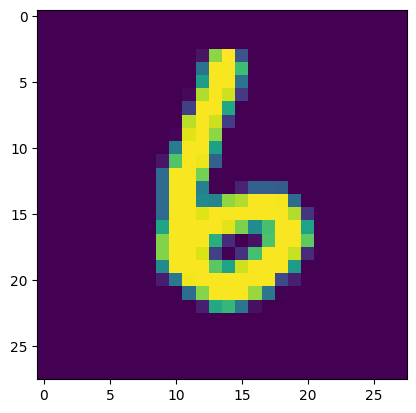

In [15]:
images, labels = val_folds[0]
index = 11234
plt.imshow(images[index].reshape((28,28)))
print(labels[index])

In [16]:
def one_training(sgd_clf, x_train, y_train, x_val, y_val, classes=None):
    if classes is not None:
        sgd_clf.partial_fit(x_train, y_train, classes=classes)
    else:
        sgd_clf.partial_fit(x_train, y_train)
    score = sgd_clf.score(x_val, y_val)
    return score

In [17]:
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
sgd_clf = SGDClassifier()

for fold_index, (X_combined_train, y_combined_train) in enumerate(train_folds):
    X_val, y_val = val_folds[fold_index]
    
    X_combined_train_scaled = scaler.fit_transform(X_combined_train)
    sgd_clf.partial_fit(X_combined_train_scaled, y_combined_train, classes=np.unique(y_combined_train))

    X_val_scaled = scaler.transform(X_val)
    score = sgd_clf.score(X_val_scaled, y_val)
    
    print(f"Fold {fold_index + 1}, Validation Accuracy: {score:f}")

Fold 1, Validation Accuracy: 0.861600
Fold 2, Validation Accuracy: 0.868850
Fold 3, Validation Accuracy: 0.877400


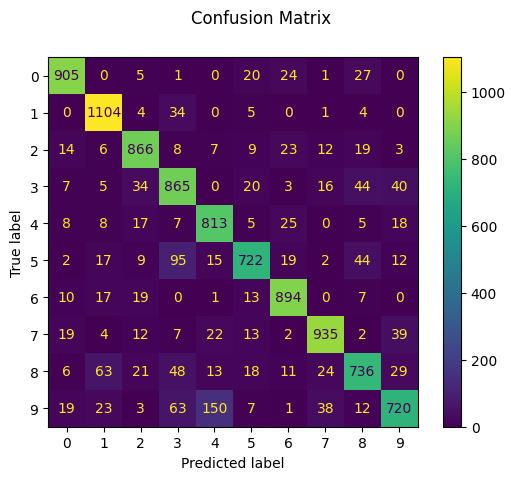

In [23]:
X_test = X_test_df.to_numpy()
X_test_scaler = scaler.fit_transform(X_test)
y_pred = sgd_clf.predict(X_test_scaler)
y_test = y_test_df.to_numpy()

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()


In [22]:
sgd_clf.score(X_test_scaler,y_test)

0.5802

In [18]:
def predict_digit_recognizer():
    test_df = pd.read_csv('digit-competition\\digit-recognizer\\test.csv')
    X_test = scaler.fit_transform(test_df.to_numpy())
    pred = sgd_clf.predict(X_test)
    predictions_df = pd.DataFrame({
        'ImageId': range(1, len(pred) + 1),
        'Label': pred
    })

    # Save the DataFrame to a CSV file
    predictions_df.to_csv('my_predictions.csv', index=False)